# Importing libraries

In [49]:
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt 
from scipy.interpolate import interp1d
from scipy.signal import tf2zpk, find_peaks, freqz
from scipy.io.wavfile import write
from librosa import feature 

In [2]:
pathToData = r"C:\\Users\\HP\\Downloads\\Commands Dataset"
pathToTrainingData = pathToData+"\\train"

Applying pre-emphasis to the signal

We can do this by passing the signal througha filter : 
$$H(z) = (1 - \alpha z^{-1}) \text{ with $\alpha$ very close to 1, typically = 0.95}$$
$$\implies y[n] = x[n] - \alpha x[n-1]$$

In [3]:
def applyPreEmphasis(data, alpha = 0.95):
    alpha = 0.95#choosing the zero for pre-emphasis
    dataPreEmph = np.array([data[n] - alpha*data[n-1] for n in range(1, len(data))])#gives singal from n=1 since we start from 1
    dataPreEmph = np.insert(dataPreEmph, 0, data[0])#intial value is same as that of x[0]
    return dataPreEmph

In [4]:
trainingData = {}
for label in os.listdir(pathToTrainingData):
    print(f"Reading '{label}' speech data")
    soundLabelAsArray = []
    for labelInstance in os.listdir(pathToTrainingData+"\\"+label):
        sampleRate, data = wavfile.read(pathToTrainingData+"\\"+label+"\\"+labelInstance) #storing the used sample rate and the wav file in variables for analysis
        data = data/(32767.0)#Normalising the data
        soundLabelAsArray.append(data)
    trainingData[label] = soundLabelAsArray

Reading 'down' speech data
Reading 'go' speech data
Reading 'left' speech data
Reading 'no' speech data
Reading 'off' speech data
Reading 'on' speech data
Reading 'right' speech data
Reading 'stop' speech data
Reading 'up' speech data
Reading 'yes' speech data


In [ ]:
acc = 0
for i in range(0, data.shape[0]-1):
    acc += np.abs(np.sign(data[i+1]) - np.sign(data[i]))

In [29]:
ff =np.array([1,2,-3,4,5,-6,-2,-6,2])
acc = 0
for i in range(0, ff.shape[0]-1):
    acc += np.abs(np.sign(ff[i+1]) - np.sign(ff[i]))

In [30]:
acc

8

In [26]:
(data[:-1]*data[1:]<0).sum()

3099

In [28]:
data

array([0.00045778, 0.00088504, 0.00045778, ..., 0.02966399, 0.03326518,
       0.02850429])

In [27]:
data[:-1]

array([0.00045778, 0.00088504, 0.00045778, ..., 0.0143437 , 0.02966399,
       0.03326518])

In [14]:
np.nonzero(np.diff(data > 0))[0].shape[0]

3172

In [5]:
data = trainingData["stop"][70]

In [17]:
dur = 0.02
samples = int(sampleRate*dur)

In [18]:
samples

320

In [19]:
ham = np.hamming(samples)

In [20]:
zcr = []
energy = []
halfSample = samples//2
for i in range(halfSample, data.shape[0]-samples):
    signalAfterhamming = data[i-halfSample:i+halfSample]*ham
    zcr.append((signalAfterhamming[:-1]*signalAfterhamming[1:]<0).sum())
    energy.append(np.sum(signalAfterhamming*signalAfterhamming))

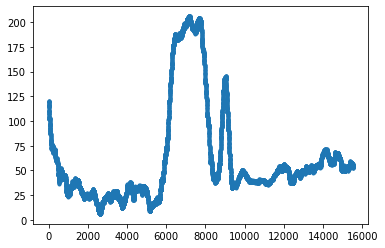

In [21]:
plt.plot(zcr, '.')

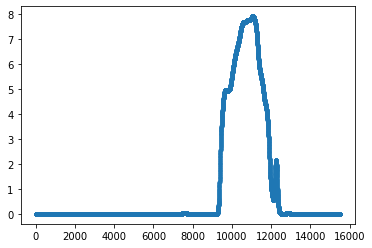

In [22]:
plt.plot(energy, '.')

In [ ]:
energyEndPointed

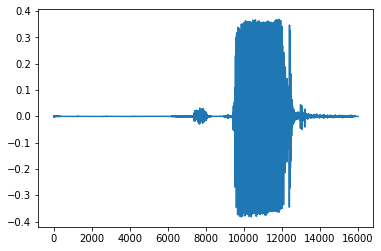

In [16]:
plt.plot(data)

# End pointing of the signal (CHNAGE THIS SHIT)

In [29]:
def end_pointing(sound_file, sr):
    # finding end points of the signal embedded using energy in 20ms window frames

    i = int(len(sound_file))
    ten_ms_count = int(sr*1e-2)
    sliced = []
    k = 0
    while k<= (i/ten_ms_count)-2:
        m = sound_file[k*ten_ms_count : (k+2)*ten_ms_count]
        sliced.append(m)
        k = k+1

    s = 0
    l = 0
    noise = 1 
    updated = 0
    e = int(len(sliced))-1
    h = np.hamming(ten_ms_count*2)

    while l<int(len(sliced)):  
        en = np.matmul(sliced[l]*h,sliced[l]*h)

        if(en > 0.005):
            if(noise == 1):
                noise = 0
                if updated == 0:
                    updated = 1
                    s = l

        if(en < 0.00001 and noise == 0):
            noise = 1
            e = l
            break

        l = l+1

    d = e-s
    if d < 50:
        e = int(len(sliced))-1

    new_sound_file = np.array(sound_file[s*ten_ms_count : (e+2)*ten_ms_count])
    return new_sound_file

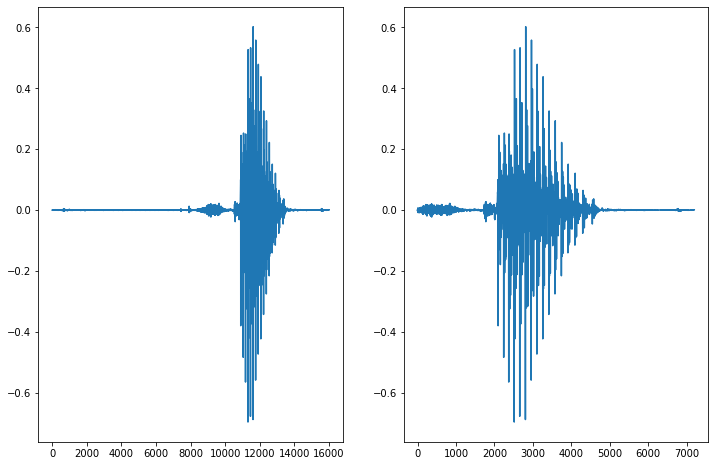

In [35]:
plt.figure(figsize=(12, 8))
str = "stop"
indx = 90
plt.subplot(121)
plt.plot(trainingData[str][indx])
plt.subplot(122)
plt.plot(end_pointing(trainingData[str][indx],sampleRate))

In [45]:
trainingLabels = [label for label in os.listdir(pathToTrainingData)]
trainingDataPreProcessed = {}
for label in trainingLabels:
    print(f"Pre processing '{label}' speech data")
    soundLabelAsArray = []
    for i in range(len(trainingData[label])):
        soundLabelAsArray.append(applyPreEmphasis(end_pointing(trainingData[label][i], sampleRate), alpha = 0.95))
    trainingDataPreProcessed[label] = soundLabelAsArray

Pre processing 'down' speech data
Pre processing 'go' speech data
Pre processing 'left' speech data
Pre processing 'no' speech data
Pre processing 'off' speech data
Pre processing 'on' speech data
Pre processing 'right' speech data
Pre processing 'stop' speech data
Pre processing 'up' speech data
Pre processing 'yes' speech data


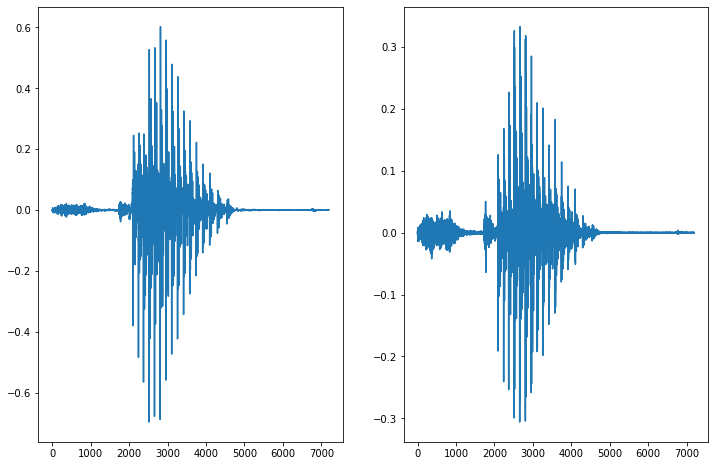

In [48]:
plt.figure(figsize=(12, 8))
str = "stop"
indx = 90
plt.subplot(121)
plt.plot(end_pointing(trainingData[str][indx],sampleRate))
plt.subplot(122)
plt.plot(trainingDataPreProcessed[str][indx])

In [96]:
mfcc = feature.mfcc(y=trainingDataPreProcessed["left"][90], sr=sampleRate, n_mfcc=13, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate))
delta1 = feature.delta(mfcc, order=1, mode = 'nearest')
delta2 = feature.delta(mfcc, order=1, mode = 'nearest')
np.r_[mfcc, delta1, delta2].shape

(39, 129)

In [98]:
melCoef = {}
for label in trainingLabels:
    print(f"Finding mel filter bank output for each instace of '{label}' speech data", end = "\t\t")
    mfccArrForLabel = []
    for i in range(len(trainingDataPreProcessed[label])):
        mfccFeatures = feature.mfcc(y=trainingDataPreProcessed[label][i], sr=sampleRate, n_mfcc=13, win_length = int(0.02*sampleRate), hop_length= int(0.005*sampleRate))
        delta1 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        delta2 = feature.delta(mfccFeatures, order=1, mode = 'nearest')
        mfccArrForLabel.append(np.r_[mfccFeatures, delta1, delta2])
    print("....finished")
    melCoef[label] = mfccArrForLabel

Finding mel filter bank output for each instace of 'down' speech data		....finished
Finding mel filter bank output for each instace of 'go' speech data		

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1760
  return f(*args, **kwargs)
C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1280
  return f(*args, **kwargs)


KeyboardInterrupt: 

In [80]:
trainingLabels

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

[Text(0.5, 1.0, 'MFCC')]

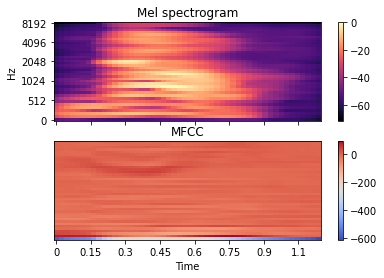

In [83]:
import librosa
import librosa.display
dur = 0.01
y, sr = trainingDataPreProcessed["no"][90], sampleRate
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, hop_length= int(dur*sampleRate),
                                   fmax=8000)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, hop_length= int(dur*sampleRate))
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')